# Tabular data analysis of Auto.ria dataset

### Summary

This notebook contains tabular data analysis of Auto.ria dataset using *scikit-learn* library. <br>
The goal was to test different algorithms with close to default settings, with minimal hyperparameter tuning.<br>
As expected, best results are shown by *Decision Tree, Random Forest, XG Boosting* algorithms, <br>
for regression *K-Nearest Neighbor* also showed good result.
<br><br>
Majority of algorithms identified **engine_size** and **year_made** as the **most important** features,<br>
and **transmission_type** and **fuel_type** as the **least important** features.

**Problems:**
- mileage == 0 <br>
car is new, or user didn't provide info?

<br><br>
**Ideas to improve performance:**
- Remove rare brands
- Remove very expensive cars, such as there are only few of them
- Get more data (especially on expensive cars)

<br><br>
**Assumptions made:**
- Electric cars should have engine size == 0;<br>
    Other types of cars should have engine size > 0
    
- Over 90% of electric cars have 'automatic' transmission type,<br>
    so it should be ok to fill electric cars' transmission type NaN values with 'automatic'

## Data preparation

In [1]:
import time
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from sklearn import model_selection
from sklearn import preprocessing

from yellowbrick.model_selection import (
    FeatureImportances, ValidationCurve, LearningCurve)
from yellowbrick.classifier import (
    ConfusionMatrix, ClassificationReport, ClassBalance)

%matplotlib inline

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'
sns.set_context('notebook')

### Load Data

In [2]:
# don't set index_col to id, such as it is mapping to images
# and if reset_index will be used, mapping to images will be broken
df = pd.read_csv('../datasets/autoria/autoria_clean_data.csv')
orig_df = df.copy()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146814 entries, 0 to 146813
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 146814 non-null  int64  
 1   brand              146814 non-null  object 
 2   price_USD          146814 non-null  int64  
 3   mileage_kkm        146814 non-null  int64  
 4   fuel_type          144972 non-null  object 
 5   transmission_type  137884 non-null  object 
 6   pub_date           146812 non-null  object 
 7   year_made          146814 non-null  int64  
 8   model              146814 non-null  object 
 9   engine_size        136162 non-null  float64
dtypes: float64(1), int64(4), object(5)
memory usage: 11.2+ MB


### Categorize price

In [4]:
price_labels = ['very_low', 'low', 'medium', 'high', 'very_high']

In [5]:
price_cats, price_bins = pd.qcut(x=df['price_USD'], q=len(price_labels), labels=price_labels, retbins=True)

In [6]:
price_bins

array([2.500e+02, 4.500e+03, 6.800e+03, 9.600e+03, 1.480e+04, 5.299e+05])

In [7]:
df['price_cat'] = price_cats

In [8]:
df.head()

,id,brand,price_USD,mileage_kkm,fuel_type,transmission_type,pub_date,year_made,model,engine_size,price_cat
0,0,Mercedes-Benz,8999,159,gas/petrol,automatic,2021-05-21,2007,E 280 4MATIC AT CLASSIC,3.0,medium
1,1,Mercedes-Benz,79900,103,diesel,automatic,2021-05-15,2015,G 350 Designo,3.0,very_high
2,2,BMW,15999,145,petrol,automatic,2021-04-18,2010,550,4.4,very_high
3,3,MINI,10200,111,petrol,automatic,2021-05-21,2014,Countryman S,1.6,high
4,4,Nissan,13900,97,petrol,automatic,2021-05-19,2010,X-Trail,2.0,high


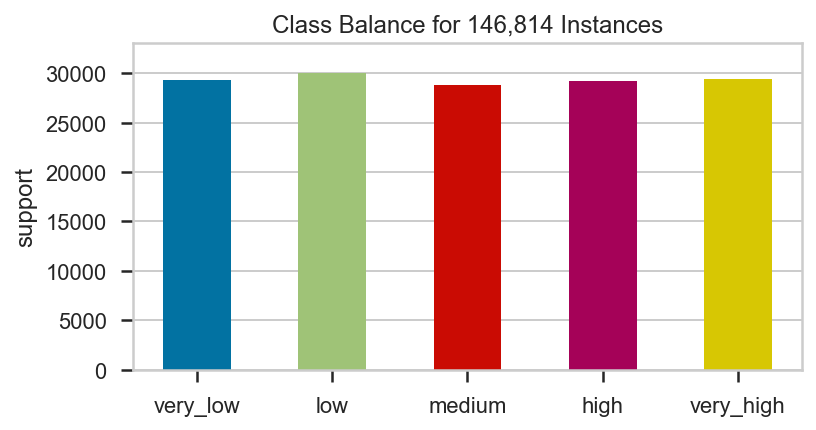

In [9]:
fig, ax = plt.subplots(figsize=(6, 3))
viz = ClassBalance(ax=ax, labels=price_labels)
viz.fit(df['price_cat'])
viz.poof()
plt.show()

### Drop unused columns

In [10]:
to_drop = ['pub_date', 'model']

df = df.drop(columns=to_drop)
df.head()

,id,brand,price_USD,mileage_kkm,fuel_type,transmission_type,year_made,engine_size,price_cat
0,0,Mercedes-Benz,8999,159,gas/petrol,automatic,2007,3.0,medium
1,1,Mercedes-Benz,79900,103,diesel,automatic,2015,3.0,very_high
2,2,BMW,15999,145,petrol,automatic,2010,4.4,very_high
3,3,MINI,10200,111,petrol,automatic,2014,1.6,high
4,4,Nissan,13900,97,petrol,automatic,2010,2.0,high


### Handle NaN values

#### Populate electric cars' NaN values

In [11]:
is_electric = df['fuel_type'] == 'electric'
df[is_electric].isna().sum()

id                      0
brand                   0
price_USD               0
mileage_kkm             0
fuel_type               0
transmission_type     350
year_made               0
engine_size          1808
price_cat               0
dtype: int64

In [12]:
df[is_electric].shape

(1852, 9)

##### Engine size

In [13]:
df[(is_electric) & (df['engine_size'] > 0)]

,id,brand,price_USD,mileage_kkm,fuel_type,transmission_type,year_made,engine_size,price_cat
34638,34638,Tesla,112240,2,electric,automatic,2020,1.8,very_high
98313,98313,Tesla,27000,130,electric,automatic,2014,1.0,very_high


In [14]:
# set engine size for electric cars equal to 0
df.loc[is_electric, 'engine_size'] = 0

##### Transmission type

In [15]:
# manual transmission for electric car? doesn't seem to be right -> drop it
df.loc[is_electric, ['brand', 'transmission_type']].groupby('transmission_type')['brand'].value_counts()

transmission_type  brand        
automatic          Nissan           459
                   Tesla            313
                   Renault          100
                   Volkswagen        73
                   BMW               70
                   Mercedes-Benz     69
                   Chevrolet         66
                   Fiat              54
                   Kia               39
                   Smart             38
                   Ford              22
                   Hyundai           14
                   Porsche           12
                   Audi              10
                   Jaguar             9
                   Toyota             7
                   Mitsubishi         5
                   Peugeot            4
                   Citroen            3
                   JAC                3
                   BAIC               2
                   Geely              2
                   Hozon              2
                   Suda               2
       

In [16]:
df[((is_electric) & (df['transmission_type'] == 'manual'))]

,id,brand,price_USD,mileage_kkm,fuel_type,transmission_type,year_made,engine_size,price_cat
52954,52954,ЗАЗ,5600,2,electric,manual,2006,0.0,low
68675,68675,ЗАЗ,5200,6,electric,manual,2004,0.0,low
99166,99166,Fiat,9000,200,electric,manual,2010,0.0,medium


In [17]:
# Drop electric with manual transmission, and reassign 'is_electric' mask
df = df[~((is_electric) & (df['transmission_type'] == 'manual'))]
is_electric = df['fuel_type'] == 'electric'

In [18]:
el_transm_count = df.loc[is_electric, 'transmission_type'].value_counts()
el_transm_count

automatic    1385
variator      100
robotic         8
tiptronic       6
Name: transmission_type, dtype: int64

In [19]:
el_transm_count / el_transm_count.sum()

automatic    0.923949
variator     0.066711
robotic      0.005337
tiptronic    0.004003
Name: transmission_type, dtype: float64

In [20]:
# fill NaN's for transmission_type in electric cars with 'automatic'
df.loc[(is_electric) & df['transmission_type'].isna(), 'transmission_type'] = 'automatic'

In [21]:
df[is_electric].isna().sum()

id                   0
brand                0
price_USD            0
mileage_kkm          0
fuel_type            0
transmission_type    0
year_made            0
engine_size          0
price_cat            0
dtype: int64

### Drop non electric cars with engine_size == 0

In [22]:
non_el_engn_size0 = (df['fuel_type'] != 'electric') & (df['engine_size'] == 0)
df = df[~non_el_engn_size0]

### Other NaN values

In [23]:
df.isnull().sum()

id                      0
brand                   0
price_USD               0
mileage_kkm             0
fuel_type            1842
transmission_type    8580
year_made               0
engine_size          8844
price_cat               0
dtype: int64

In [24]:
df.isna().any(axis=1).sum(), df.shape[0]

(17497, 146789)

We could potentially search if there are same car models with NaN's and with filled values, <br>
and fill NaN's this way, but let's for now just drop all the rest missing values.

In [25]:
df.dropna(inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129292 entries, 0 to 146813
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   id                 129292 non-null  int64   
 1   brand              129292 non-null  object  
 2   price_USD          129292 non-null  int64   
 3   mileage_kkm        129292 non-null  int64   
 4   fuel_type          129292 non-null  object  
 5   transmission_type  129292 non-null  object  
 6   year_made          129292 non-null  int64   
 7   engine_size        129292 non-null  float64 
 8   price_cat          129292 non-null  category
dtypes: category(1), float64(1), int64(4), object(3)
memory usage: 9.0+ MB


### Encode categorical values

In [27]:
df.head()

,id,brand,price_USD,mileage_kkm,fuel_type,transmission_type,year_made,engine_size,price_cat
0,0,Mercedes-Benz,8999,159,gas/petrol,automatic,2007,3.0,medium
1,1,Mercedes-Benz,79900,103,diesel,automatic,2015,3.0,very_high
2,2,BMW,15999,145,petrol,automatic,2010,4.4,very_high
3,3,MINI,10200,111,petrol,automatic,2014,1.6,high
4,4,Nissan,13900,97,petrol,automatic,2010,2.0,high


In [28]:
df['brand'].unique().size

138

In [29]:
cat_cols = ['brand', 'fuel_type', 'transmission_type', 'price_cat']
num_cols = [col 
            for col in df.columns 
            if col not in cat_cols]

In [30]:
d = defaultdict(preprocessing.LabelEncoder)

# encode
fit = df[cat_cols].apply(lambda col: d[col.name].fit_transform(col))
df = pd.concat([fit, df[num_cols]], axis=1)

In [31]:
df.describe()

,brand,fuel_type,transmission_type,price_cat,id,price_USD,mileage_kkm,year_made,engine_size
count,129292.000000,129292.000000,129292.000000,129292.000000,129292.000000,129292.000000,129292.000000,129292.000000,129292.000000
mean,72.523528,2.855211,0.742830,1.956239,73163.114060,11785.000526,181.216657,2008.542632,1.991526
std,37.090052,2.173193,0.819103,1.403620,42422.167518,16286.053639,101.375607,7.305473,0.742446
min,0.000000,0.000000,0.000000,0.000000,0.000000,250.000000,0.000000,1900.000000,0.000000
25%,36.000000,0.000000,0.000000,1.000000,36422.750000,5300.000000,113.000000,2005.000000,1.600000
50%,79.000000,3.000000,1.000000,2.000000,73158.500000,8200.000000,180.000000,2009.000000,1.900000
75%,102.000000,5.000000,1.000000,3.000000,109903.250000,13300.000000,235.000000,2014.000000,2.200000
max,137.000000,5.000000,4.000000,4.000000,146813.000000,529900.000000,999.000000,2021.000000,7.400000


In [32]:
d['fuel_type'].classes_

array(['diesel', 'electric', 'gas', 'gas/petrol', 'hybrid', 'petrol'],
      dtype=object)

#### Decode & inference

In [33]:
# decode
fit.apply(lambda col: d[col.name].inverse_transform(col)).head()

,brand,fuel_type,transmission_type,price_cat
0,Mercedes-Benz,gas/petrol,automatic,medium
1,Mercedes-Benz,diesel,automatic,very_high
2,BMW,petrol,automatic,very_high
3,MINI,petrol,automatic,high
4,Nissan,petrol,automatic,high


In [34]:
orig_df.head()

,id,brand,price_USD,mileage_kkm,fuel_type,transmission_type,pub_date,year_made,model,engine_size
0,0,Mercedes-Benz,8999,159,gas/petrol,automatic,2021-05-21,2007,E 280 4MATIC AT CLASSIC,3.0
1,1,Mercedes-Benz,79900,103,diesel,automatic,2021-05-15,2015,G 350 Designo,3.0
2,2,BMW,15999,145,petrol,automatic,2021-04-18,2010,550,4.4
3,3,MINI,10200,111,petrol,automatic,2021-05-21,2014,Countryman S,1.6
4,4,Nissan,13900,97,petrol,automatic,2021-05-19,2010,X-Trail,2.0


In [35]:
# Using the dictionary to label future data
orig_df[['fuel_type', 'transmission_type']].dropna().apply(lambda c: d[c.name].transform(c))

,fuel_type,transmission_type
0,3,0
1,0,0
2,5,0
3,5,0
4,5,0
...,...,...
146809,0,1
146810,5,1
146811,5,0
146812,5,1


### Clean / encode / save

In [34]:
df = pd.read_csv('../datasets/autoria/autoria_clean_data.csv')

#### Clean

In [35]:
df.brand.head()

0    Mercedes-Benz
1    Mercedes-Benz
2              BMW
3             MINI
4           Nissan
Name: brand, dtype: object

In [36]:
df['brand'] = df['brand'].str.lower()
df.brand.head()

0    mercedes-benz
1    mercedes-benz
2              bmw
3             mini
4           nissan
Name: brand, dtype: object

In [37]:
is_electric = df['fuel_type'] == 'electric'

In [38]:
df.drop(columns=['id', 'pub_date', 'model'], inplace=True)
# set engine size for electric cars equal to 0
df.loc[is_electric, 'engine_size'] = 0

# Drop electric with manual transmission, and reassign 'is_electric' mask
df = df[~((is_electric) & (df['transmission_type'] == 'manual'))]
# fill NaN's for transmission_type in electric cars with 'automatic'
df.loc[(is_electric) & df['transmission_type'].isna(), 'transmission_type'] = 'automatic'
# drop non electric cars with engine_size == 0
non_el_engn_size0 = (df['fuel_type'] != 'electric') & (df['engine_size'] == 0)
df = df[~non_el_engn_size0]
df.dropna(inplace=True)

#### Encode categorical values

In [39]:
# encode categorical values
cat_cols = ['brand', 'fuel_type', 'transmission_type']
num_cols = [col 
            for col in df.columns 
            if col not in cat_cols]

d = defaultdict(preprocessing.LabelEncoder)

# encode
fit = df[cat_cols].apply(lambda col: d[col.name].fit_transform(col))
df = pd.concat([fit, df[num_cols]], axis=1)

In [40]:
df

,brand,fuel_type,transmission_type,price_USD,mileage_kkm,year_made,engine_size
0,74,3,0,8999,159,2007,3.0
1,74,0,0,79900,103,2015,3.0
2,11,5,0,15999,145,2010,4.4
3,77,5,0,10200,111,2014,1.6
4,81,5,0,13900,97,2010,2.0
...,...,...,...,...,...,...,...
146807,116,5,1,4800,200,2001,1.6
146808,101,0,1,15200,170,2015,2.0
146809,90,0,1,6100,260,2008,1.5
146811,11,5,0,18000,70,2011,2.0


#### Save

In [41]:
import pickle

In [42]:
feature_encoding_path = '../datasets/autoria/feature_encoding.pkl'
encoded_csv_path = '../datasets/autoria/autoria_encoded_data.csv'

##### Save data

In [43]:
df.to_csv(encoded_csv_path)

In [44]:
encoded_df = pd.read_csv(encoded_csv_path, index_col=0)

In [45]:
encoded_df

,brand,fuel_type,transmission_type,price_USD,mileage_kkm,year_made,engine_size
0,74,3,0,8999,159,2007,3.0
1,74,0,0,79900,103,2015,3.0
2,11,5,0,15999,145,2010,4.4
3,77,5,0,10200,111,2014,1.6
4,81,5,0,13900,97,2010,2.0
...,...,...,...,...,...,...,...
146807,116,5,1,4800,200,2001,1.6
146808,101,0,1,15200,170,2015,2.0
146809,90,0,1,6100,260,2008,1.5
146811,11,5,0,18000,70,2011,2.0


##### Save encoding

In [46]:
with open(feature_encoding_path, 'wb') as f:
    pickle.dump(d, f)

In [47]:
with open(feature_encoding_path, 'rb') as f:
    encoding = pickle.load(f)

In [48]:
encoding

defaultdict(sklearn.preprocessing._label.LabelEncoder,
            {'brand': LabelEncoder(),
             'fuel_type': LabelEncoder(),
             'transmission_type': LabelEncoder()})

In [50]:
encoding['brand'].transform(['bmw'])

array([11])

### Split data into train/test sets

In [36]:
df.set_index('id', inplace=True)

In [37]:
# classification target
y = df['price_cat']

# regression target
yr = df['price_USD']

X = df.drop(columns = ['price_cat', 'price_USD'])

In [38]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42
)

In [39]:
X_train.shape, X_test.shape

((90504, 6), (38788, 6))

In [40]:
y_train.shape, y_test.shape

((90504,), (38788,))

## Classification

### Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
lreg = LogisticRegression(
    random_state=1,
    solver='newton-cg',
    max_iter=100,
    n_jobs=-1,
)

lreg.fit(X_train, y_train)
lreg.score(X_test, y_test)

0.5515107765288233

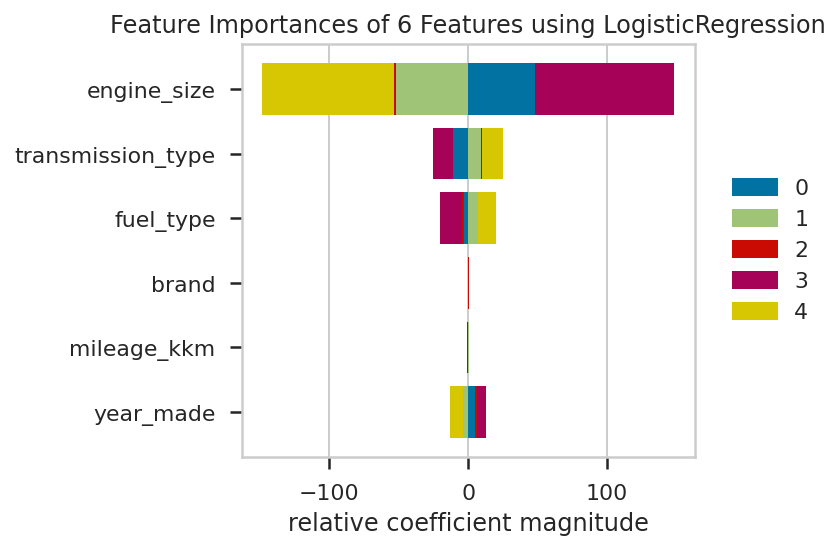

In [44]:
fig, ax = plt.subplots(figsize=(6, 4))
viz = FeatureImportances(lreg, ax=ax, stack=True)
viz.fit(X_train, y_train)
viz.poof()
plt.show()

### Naive Bayes

In [45]:
from sklearn.naive_bayes import MultinomialNB

In [46]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [47]:
nb.score(X_test, y_test)

0.3274981953181396

### Support Vector Machine

In [48]:
from sklearn.svm import SVC

In [49]:
svc = SVC(random_state=1)
svc.fit(X_train[:20000], y_train[:20000])

SVC(random_state=1)

In [50]:
svc.score(X_test, y_test)

0.3468856347323915

### K-Nearest Neighbor

In [51]:
from sklearn.neighbors import KNeighborsClassifier

In [52]:
knc = KNeighborsClassifier(n_jobs=-1)
knc.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [53]:
knc.score(X_test, y_test)

0.6391151902650304

### Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier

In [55]:
dtc = DecisionTreeClassifier(
    max_depth=10,
    random_state=1,
)

dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=1)

In [56]:
dtc.score(X_test, y_test)

0.7135712075899763

In [57]:
dtc.score(X_train, y_train)

0.7228188809334394

In [58]:
dtc_pred = dtc.predict(X_test)

In [59]:
X_train.columns.values

array(['brand', 'fuel_type', 'transmission_type', 'mileage_kkm',
       'year_made', 'engine_size'], dtype=object)

In [60]:
col_importance = zip(X_train.columns.values, dtc.feature_importances_)
sorted(list(col_importance), key=lambda x: x[1], reverse=True)

[('year_made', 0.4818841477560971),
 ('engine_size', 0.2782901749912937),
 ('brand', 0.18288981570755977),
 ('mileage_kkm', 0.03323449124971822),
 ('fuel_type', 0.014615893348531486),
 ('transmission_type', 0.009085476946799788)]

#### Feature importances

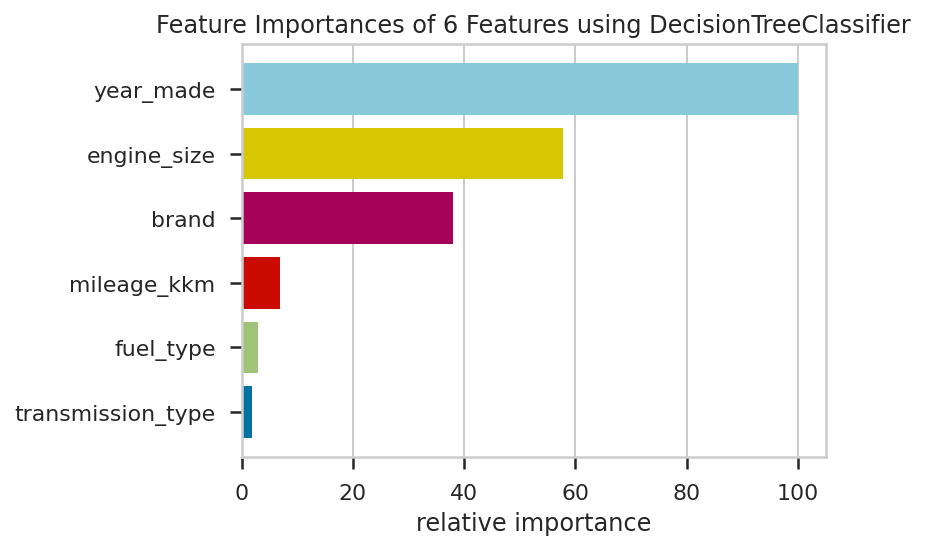

In [61]:
fig, ax = plt.subplots(figsize=(6, 4))
viz = FeatureImportances(dtc)
viz.fit(X_train, y_train)
viz.poof()
plt.show()

#### Confusion matrix

In [62]:
classes = ['very_low', 'low', 'medium', 'high', 'very_high']

/usr/local/lib/python3.6/dist-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


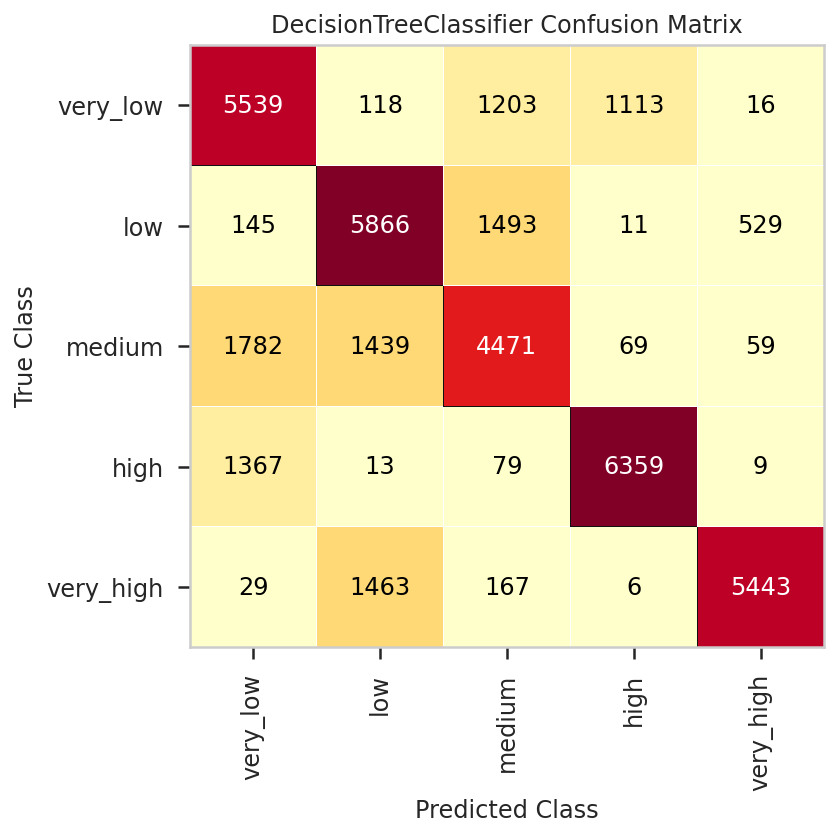

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(dtc, 
                         classes=classes,)

cm_viz.score(X_test, y_test)
cm_viz.poof()
plt.show()

#### Classification report

/usr/local/lib/python3.6/dist-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


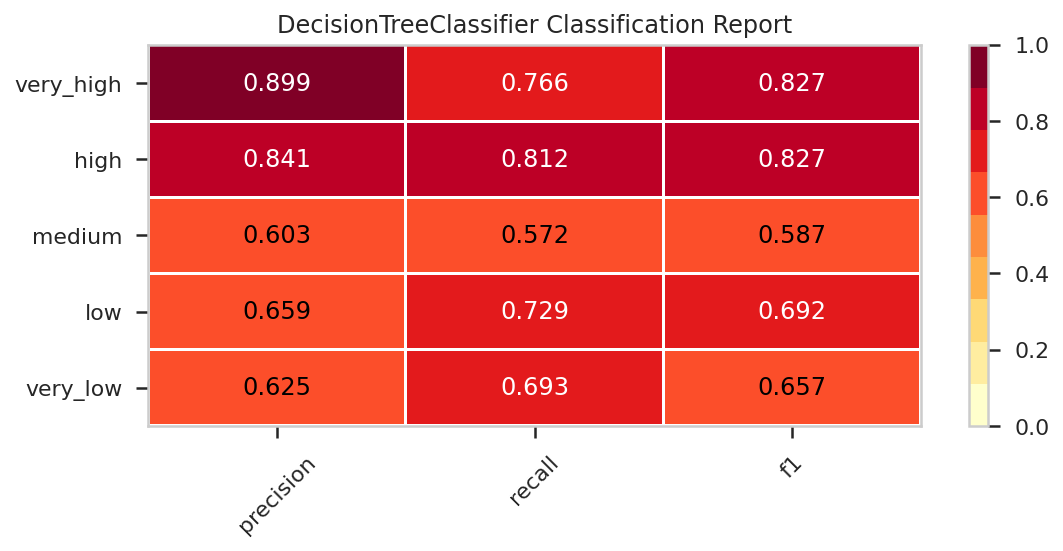

In [64]:
fig, ax = plt.subplots(figsize=(8, 4))
cr = ClassificationReport(dtc, 
                          classes=classes)
cr.score(X_test, y_test)
cr.poof()
plt.show()

### Random Forest

`rfpimp.importances`

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
rfc = RandomForestClassifier(
    max_depth=12,
    random_state=1,
    n_jobs=-1
)

rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_jobs=-1, random_state=1)

In [67]:
rfc.score(X_test, y_test)

0.7489945343920801

In [68]:
rfc.score(X_train, y_train)

0.7768054450632016

#### Feature importances

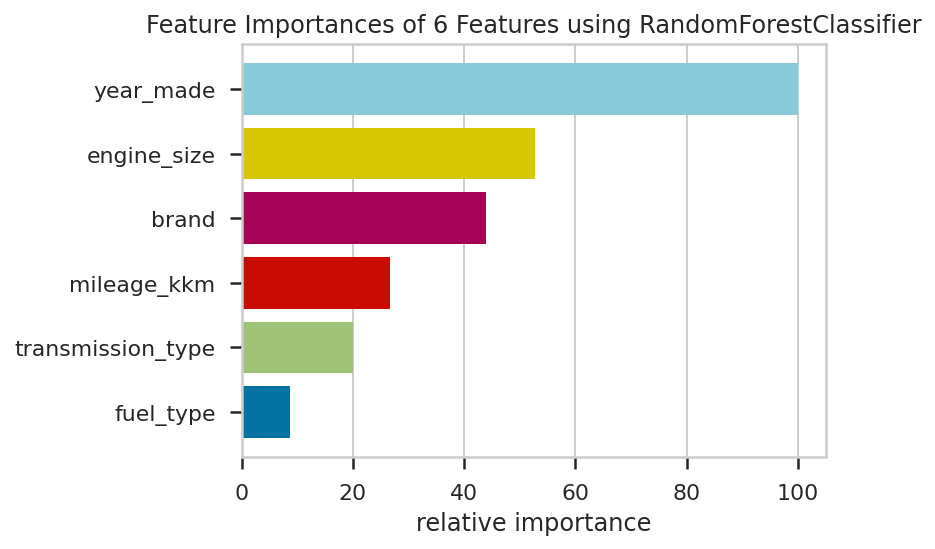

In [69]:
fig, ax = plt.subplots(figsize=(6, 4))
viz = FeatureImportances(rfc)
viz.fit(X_train, y_train)
viz.poof()
plt.show()

#### Validation curve

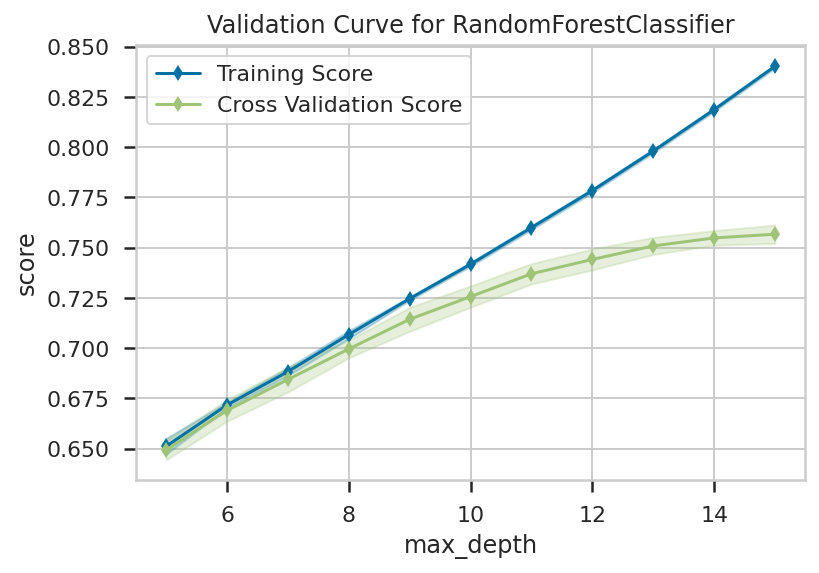

In [70]:
fig, ax = plt.subplots(figsize=(6, 4))
vc_viz = ValidationCurve(
    RandomForestClassifier(n_jobs=6),
    param_name='max_depth',
    param_range=np.arange(5, 16),
    cv=10,
    n_jobs=6
)

vc_viz.fit(X_train, y_train)
vc_viz.poof()
plt.show()

#### Learning curve

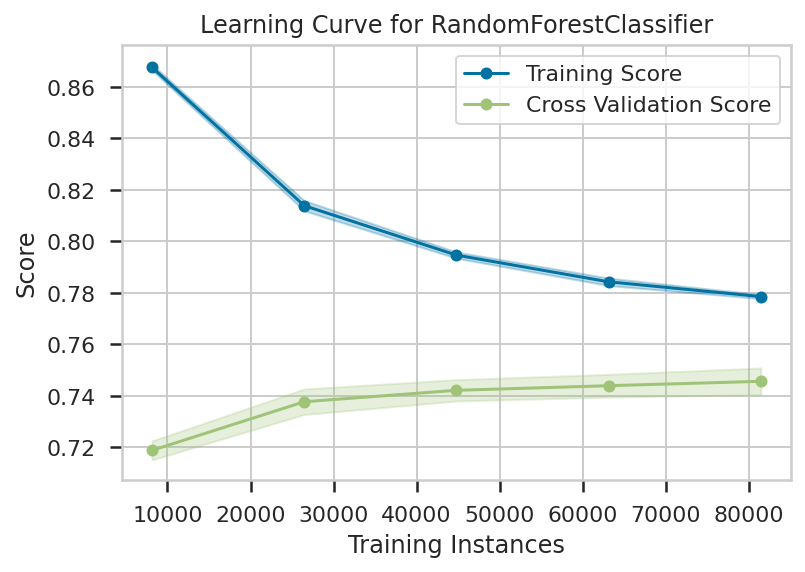

In [71]:
fig, ax = plt.subplots(figsize=(6, 4))
lc_viz = LearningCurve(
    RandomForestClassifier(max_depth=12, n_jobs=6),
    cv=10,
    n_jobs=6,
)

lc_viz.fit(X_train, y_train)
lc_viz.poof()
plt.show()

#### Confusion matrix

/usr/local/lib/python3.6/dist-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


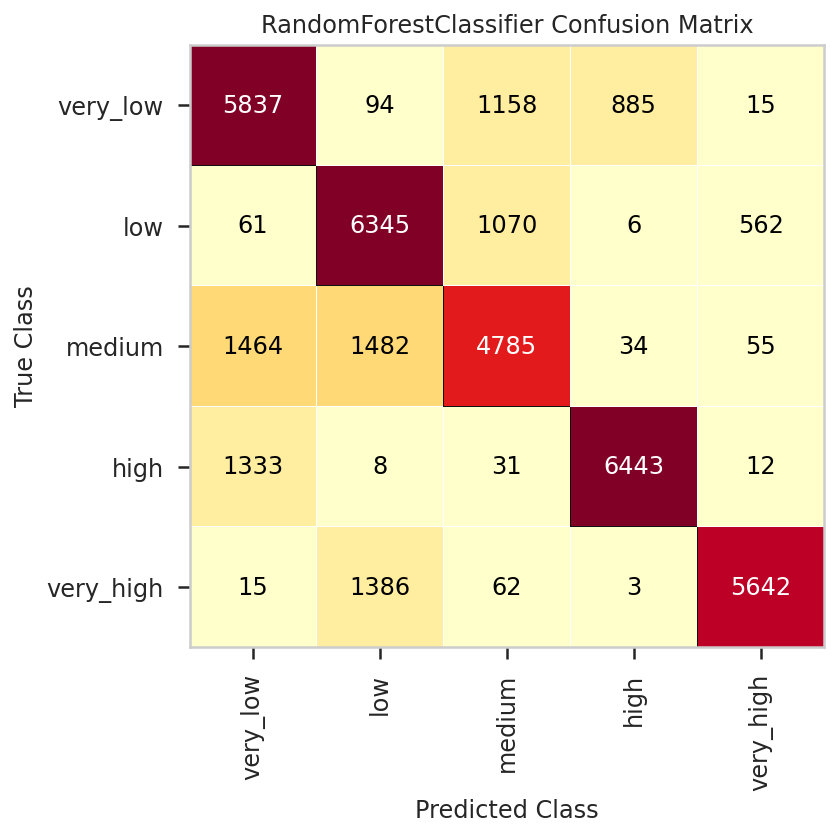

In [72]:
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(rfc, 
                         classes=classes,)

cm_viz.score(X_test, y_test)
cm_viz.poof()
plt.show()

### XGBoost

The `xgbfir` package is a library built on top of XGBoost. This library gives
various measures about feature importance.

In [73]:
import xgboost as xgb

In [74]:
xgbc = xgb.XGBClassifier(random_state=1, use_label_encoder=False, n_jobs=6)
xgbc.fit(X_train, y_train, 
         eval_metric='merror', 
         early_stopping_rounds=2, 
         eval_set=[(X_test, y_test)])

[0]	validation_0-merror:0.32982
[1]	validation_0-merror:0.31133
[2]	validation_0-merror:0.30958
[3]	validation_0-merror:0.30182
[4]	validation_0-merror:0.29646
[5]	validation_0-merror:0.29246
[6]	validation_0-merror:0.28803
[7]	validation_0-merror:0.28292
[8]	validation_0-merror:0.28063
[9]	validation_0-merror:0.27661
[10]	validation_0-merror:0.27480
[11]	validation_0-merror:0.27114
[12]	validation_0-merror:0.26972
[13]	validation_0-merror:0.26624
[14]	validation_0-merror:0.26493
[15]	validation_0-merror:0.26294
[16]	validation_0-merror:0.26207
[17]	validation_0-merror:0.26080
[18]	validation_0-merror:0.25923
[19]	validation_0-merror:0.25773
[20]	validation_0-merror:0.25552
[21]	validation_0-merror:0.25570
[22]	validation_0-merror:0.25456
[23]	validation_0-merror:0.25302
[24]	validation_0-merror:0.25250
[25]	validation_0-merror:0.25080
[26]	validation_0-merror:0.25023
[27]	validation_0-merror:0.24892
[28]	validation_0-merror:0.24851
[29]	validation_0-merror:0.24781
[30]	validation_0-me

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [75]:
xgbc.score(X_test, y_test)

0.7675054140455811

In [76]:
xgbc.score(X_train, y_train)

0.7884513391673296

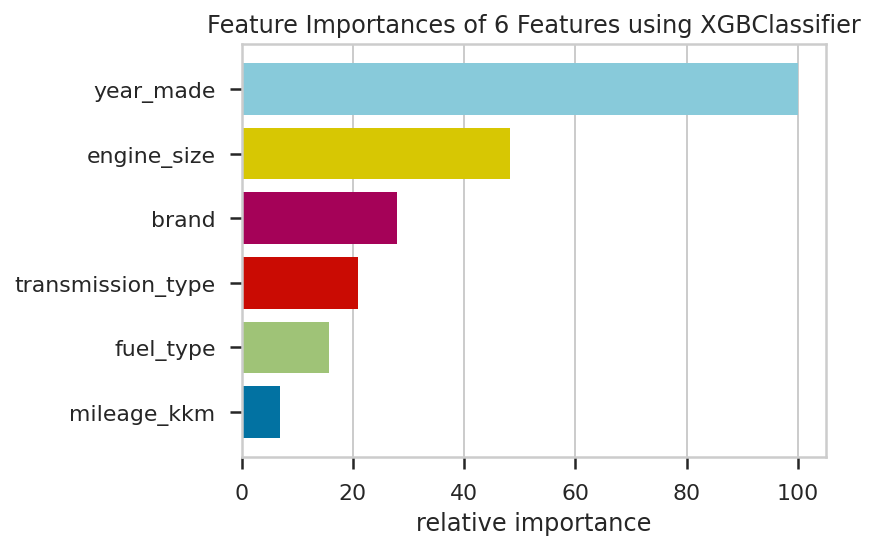

In [77]:
fig, ax = plt.subplots(figsize=(6, 4))
viz = FeatureImportances(xgbc)
viz.fit(X_train, y_train)
viz.poof()
plt.show()

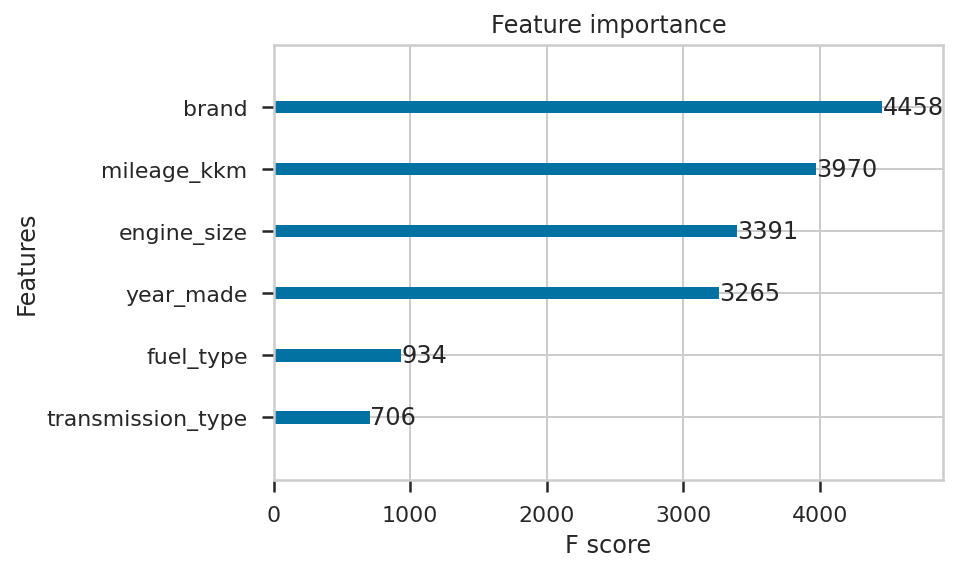

In [78]:
fig, ax = plt.subplots(figsize=(6, 4))
xgb.plot_importance(xgbc, ax=ax)
plt.show()

## Regression

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae

from yellowbrick.features import FeatureImportances
from yellowbrick.regressor import ResidualsPlot, PredictionError

### Utils

In [42]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mrae(y_true, y_pred):
    """Return `Mean Relative Absolute Error`"""
    return ((y_true - y_pred).abs() / y_true).mean()


def print_metrics(y_true, y_pred):
    print('{:5} {:.2f}'.format('rmse:', rmse(y_true, y_pred)))
    print('{:5} {:.2f}'.format('mae:', mae(y_true, y_pred)))
    print('{:5} {:.2f}'.format('mrae:', mrae(y_true, y_pred)))


def print_test_train_metrics(estimator, X_train, X_test, y_train, y_test):
    print('Test Metrics')
    print_metrics(y_test, estimator.predict(X_test))
    print('\nTraining Metrics')
    print_metrics(y_train, estimator.predict(X_train))

### Data preparation

In [43]:
X_trr, X_tsr, y_trr, y_tsr = model_selection.train_test_split(
    X, yr,
    test_size=0.3,
    random_state=42
)

In [44]:
X.head()

,brand,fuel_type,transmission_type,mileage_kkm,year_made,engine_size
id,,,,,,
0,77,3,0,159,2007,3.0
1,77,0,0,103,2015,3.0
2,8,5,0,145,2010,4.4
3,71,5,0,111,2014,1.6
4,81,5,0,97,2010,2.0


Standardize mileage and engine_size

In [45]:
Xst = X.copy()

In [46]:
Xst.loc[:, ['mileage_kkm', 'engine_size']] = preprocessing.StandardScaler()\
    .fit_transform(X[['mileage_kkm', 'engine_size']])

In [47]:
Xst.describe()

,brand,fuel_type,transmission_type,mileage_kkm,year_made,engine_size
count,129292.000000,129292.000000,129292.000000,1.292920e+05,129292.000000,1.292920e+05
mean,72.523528,2.855211,0.742830,1.231024e-17,2008.542632,4.025009e-16
std,37.090052,2.173193,0.819103,1.000004e+00,7.305473,1.000004e+00
min,0.000000,0.000000,0.000000,-1.787583e+00,1900.000000,-2.682395e+00
25%,36.000000,0.000000,0.000000,-6.729126e-01,2005.000000,-5.273479e-01
50%,79.000000,3.000000,1.000000,-1.200152e-02,2009.000000,-1.232765e-01
75%,102.000000,5.000000,1.000000,5.305374e-01,2014.000000,2.807949e-01
max,137.000000,5.000000,4.000000,8.066896e+00,2021.000000,7.284699e+00


In [48]:
Xs_trr, Xs_tsr, ys_trr, ys_tsr = model_selection.train_test_split(
    Xst, yr,
    test_size=0.3,
    random_state=42
)

In [49]:
data = [X_trr, X_tsr, y_trr, y_tsr]
data_st = [Xs_trr, Xs_tsr, ys_trr, ys_tsr]

### Baseline model

In [88]:
from sklearn.dummy import DummyRegressor

In [89]:
dr = DummyRegressor()
dr.fit(X_trr, y_trr)
dr.score(X_tsr, y_tsr)

-4.079123447464639e-06

In [90]:
print_test_train_metrics(dr, *data)

Test Metrics
rmse: 16523.31
mae:  7464.45
mrae: 1.15

Training Metrics
rmse: 16183.22
mae:  7419.81
mrae: 1.15


### Linear regression

In [91]:
from sklearn.linear_model import LinearRegression

In [92]:
lr = LinearRegression(n_jobs=6)
lr.fit(X_trr, y_trr)
lr.score(X_tsr, y_tsr)

0.3206088861548805

In [93]:
print_test_train_metrics(lr, *data)

Test Metrics
rmse: 13619.34
mae:  5562.32
mrae: 0.77

Training Metrics
rmse: 13332.72
mae:  5517.33
mrae: 0.77


In [94]:
# Standardized
lrs = LinearRegression(n_jobs=6)
lrs.fit(Xs_trr, ys_trr)
print('score:', lrs.score(Xs_tsr, ys_tsr))

print_test_train_metrics(lrs, *data_st)

score: 0.3206088861548805
Test Metrics
rmse: 13619.34
mae:  5562.32
mrae: 0.77

Training Metrics
rmse: 13332.72
mae:  5517.33
mrae: 0.77


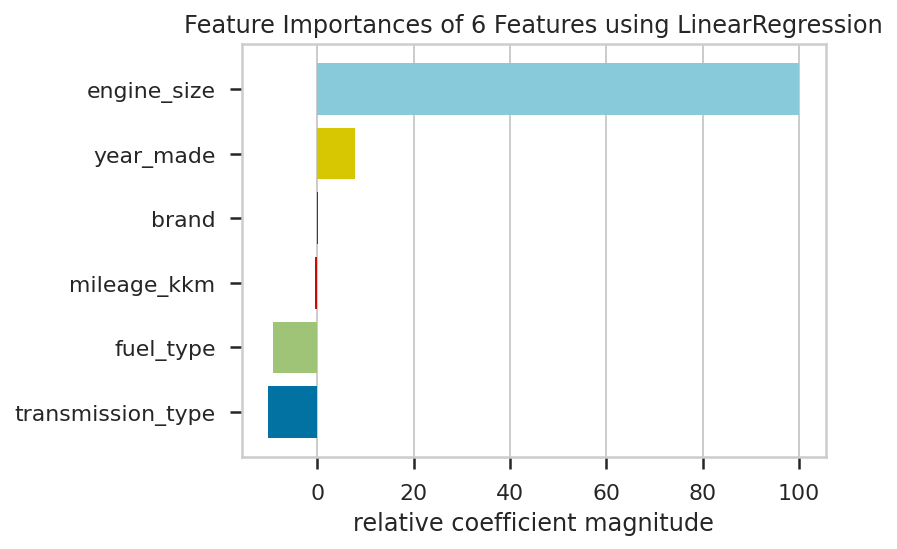

In [95]:
# So, linear regression doesn't work with to many categories (brand)
fig, ax = plt.subplots(figsize=(6, 4))
viz = FeatureImportances(lr)
viz.fit(X_tsr, y_tsr)
viz.poof()
plt.show()

### SVMs

In [96]:
from sklearn.svm import SVR

SAMPLE_SIZE = 5000

In [97]:
svr = SVR()
svr.fit(X_trr[:SAMPLE_SIZE], y_trr[:SAMPLE_SIZE])
print(svr.score(X_tsr[:SAMPLE_SIZE], y_tsr[:SAMPLE_SIZE]))

print_test_train_metrics(lr, *[d[:SAMPLE_SIZE] for d in data])

-0.04626168238086925
Test Metrics
rmse: 1191921.59
mae:  1191813.58
mrae: 195.37

Training Metrics
rmse: 1192168.71
mae:  1192050.48
mrae: 195.41


In [98]:
# Standardized
svr_s = SVR()
svr_s.fit(Xs_trr[:SAMPLE_SIZE], ys_trr[:SAMPLE_SIZE])
print('score:', svr_s.score(Xs_tsr[:SAMPLE_SIZE], ys_tsr[:SAMPLE_SIZE]))

print_test_train_metrics(svr_s, *[d[:SAMPLE_SIZE] for d in data_st])

score: -0.04669063186733102
Test Metrics
rmse: 16483.66
mae:  6597.76
mrae: 0.74

Training Metrics
rmse: 17262.70
mae:  6846.76
mrae: 0.75


### K-Nearest Neighbor

In [99]:
from sklearn.neighbors import KNeighborsRegressor

In [100]:
knr = KNeighborsRegressor(n_neighbors=10)
knr.fit(X_trr, y_trr)
print(knr.score(X_tsr, y_tsr))

print_test_train_metrics(knr, *data)

0.8038986395304365
Test Metrics
rmse: 7317.06
mae:  2840.07
mrae: 0.25

Training Metrics
rmse: 6588.52
mae:  2533.30
mrae: 0.22


In [101]:
# Standardized
knr_s = KNeighborsRegressor(n_neighbors=10)
knr_s.fit(Xs_trr, ys_trr)
print(knr_s.score(Xs_tsr, ys_tsr))

print_test_train_metrics(knr_s, *data_st)

0.8927482026525724
Test Metrics
rmse: 5411.26
mae:  1948.53
mrae: 0.17

Training Metrics
rmse: 5053.56
mae:  1764.12
mrae: 0.16


### Decision Tree

In [102]:
from sklearn.tree import DecisionTreeRegressor

In [103]:
dtr = DecisionTreeRegressor(
    max_depth=14,
    random_state=1,)
dtr.fit(X_trr, y_trr)
print('score:', dtr.score(X_tsr, y_tsr))

print_test_train_metrics(dtr, *data)

score: 0.8672286172797206
Test Metrics
rmse: 6020.72
mae:  2095.34
mrae: 0.18

Training Metrics
rmse: 3399.64
mae:  1499.19
mrae: 0.16


#### Feature importances

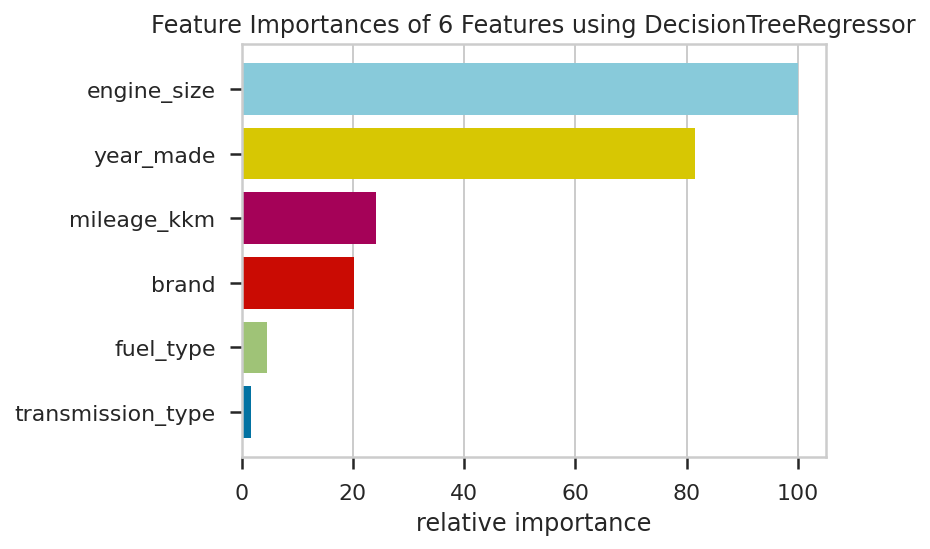

In [104]:
fig, ax = plt.subplots(figsize=(6, 4))
viz = FeatureImportances(dtr)
viz.fit(X_trr, y_trr)
viz.poof()
plt.show()

### Random Forest

In [105]:
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

In [106]:
rfr = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=1,
    n_jobs=8,
)
rfr.fit(X_trr, y_trr)
print('score:', rfr.score(X_tsr, y_tsr))

print_test_train_metrics(rfr, *data)

score: 0.8991753876805324
Test Metrics
rmse: 5246.62
mae:  1866.91
mrae: 0.17

Training Metrics
rmse: 3399.33
mae:  1414.14
mrae: 0.14


#### Feature importances

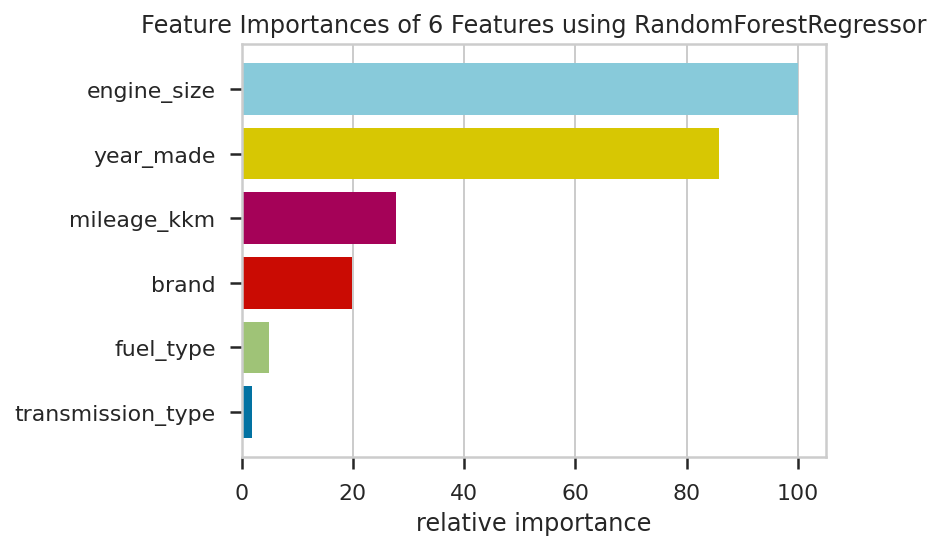

In [107]:
fig, ax = plt.subplots(figsize=(6, 4))
viz = FeatureImportances(rfr)
viz.fit(X_tsr, y_tsr)
viz.poof()
plt.show()

#### Residuals plot (prediction error)

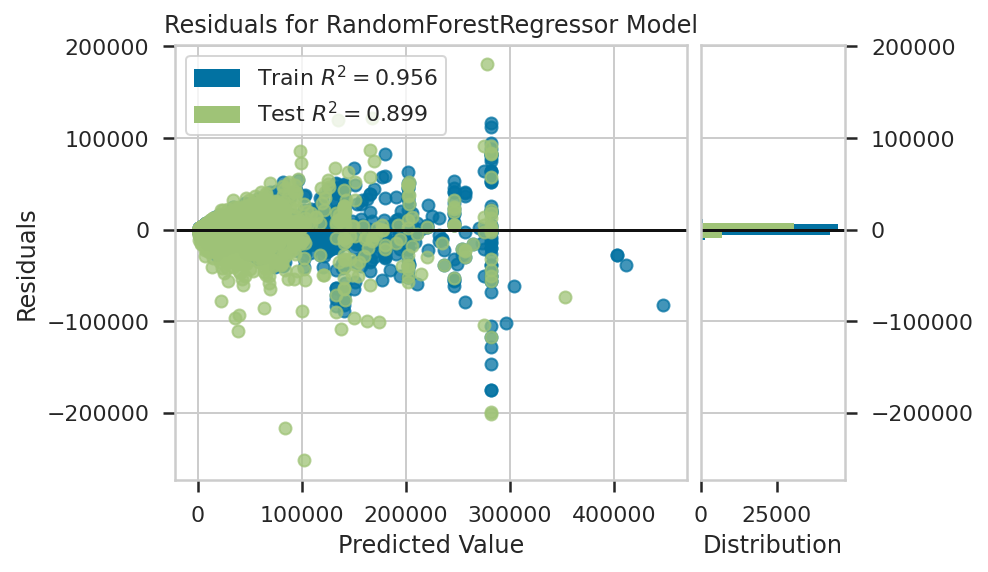

In [108]:
fig, ax = plt.subplots(figsize=(6, 4))
rpv = ResidualsPlot(rfr, ax=ax)
rpv.fit(X_trr, y_trr)
rpv.score(X_tsr, y_tsr)
rpv.poof()
plt.show()

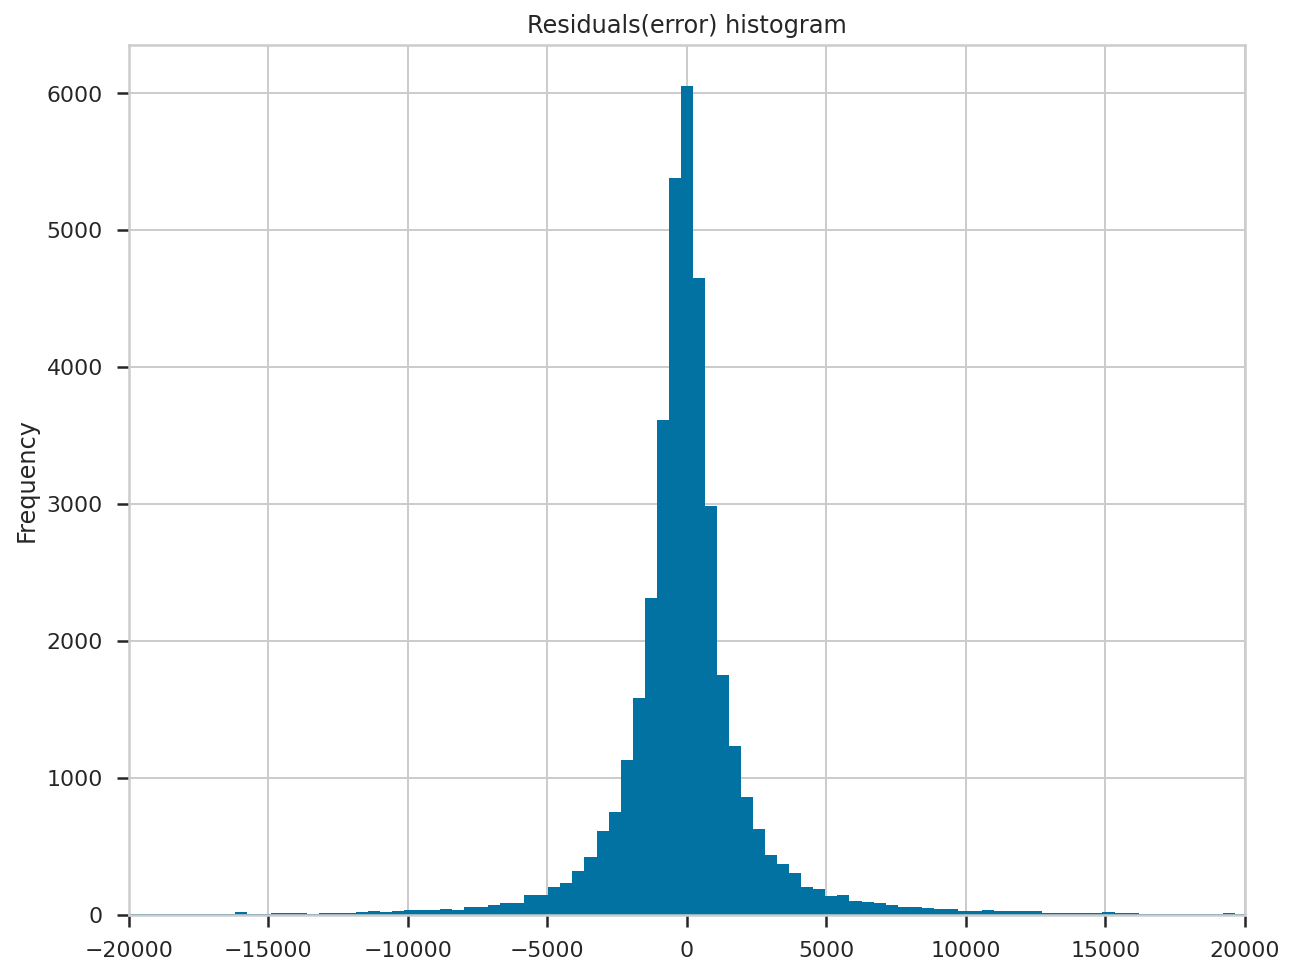

In [109]:
fig, ax = plt.subplots(figsize=(10, 8))
resids = y_tsr - rfr.predict(X_tsr)
pd.Series(resids, name='residuals').plot.hist(
    bins=1000,
    ax=ax,
    title='Residuals(error) histogram'
)

ax.axis(xmin=-20000, xmax=20000)
plt.show()

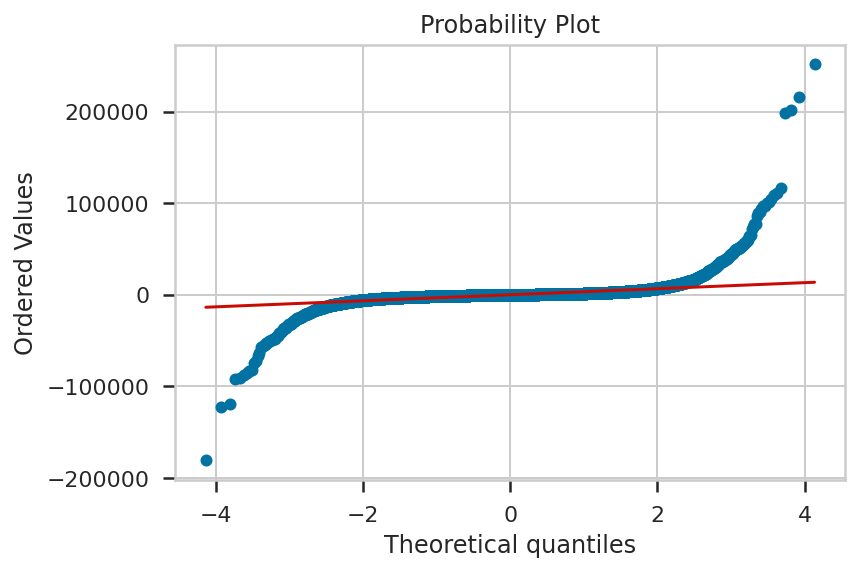

In [110]:
fig, ax = plt.subplots(figsize=(6, 4))
_ = stats.probplot(resids, plot=ax)
plt.show()

The Kolmogorov-Smirnov test can evaluate whether a distribution is normal. <br>
If the p-value is significant (< 0.05), then the values are not normal.<br>
This fails, which tells us the residuals are not normal:

In [111]:
stats.kstest(resids, cdf='norm')

KstestResult(statistic=0.5345318764708121, pvalue=0.0)

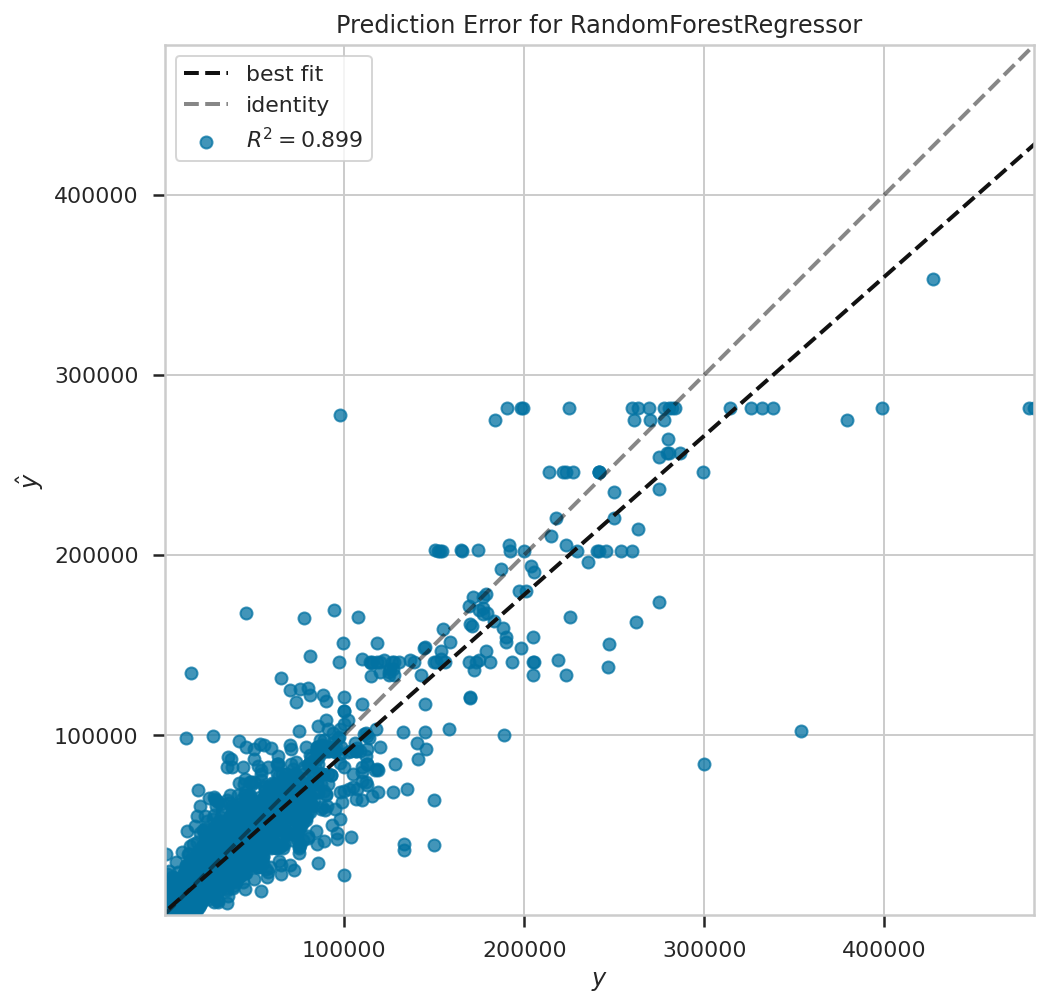

In [112]:
fig, ax = plt.subplots(figsize=(8, 8))
pe = PredictionError(rfr, ax=ax)
pe.fit(X_trr, y_trr)
pe.score(X_tsr, y_tsr)
pe.poof()
plt.show()

### XGBoost Regression

In [113]:
import xgboost as xgb

In [114]:
xgr = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=1,
    n_jobs=8,
)
xgr.fit(X_trr, y_trr)
print('score:', xgr.score(X_tsr, y_tsr))

print_test_train_metrics(xgr, *data)

score: 0.8989688390429196
Test Metrics
rmse: 5251.99
mae:  1810.32
mrae: 0.16

Training Metrics
rmse: 3028.21
mae:  1215.78
mrae: 0.12


#### Feature importances

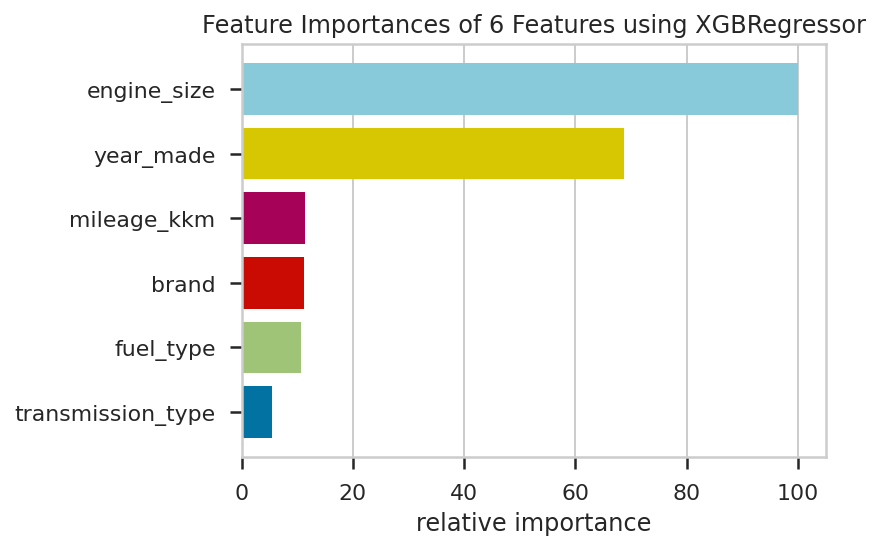

In [115]:
fig, ax = plt.subplots(figsize=(6, 4))
viz = FeatureImportances(xgr)
viz.fit(X_tsr, y_tsr)
viz.poof()
plt.show()

### Simple Neural Network

In [50]:
import tensorflow as tf
from tensorflow.keras import layers

In [68]:
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [69]:
history = model.fit(X_trr, y_trr, 
                    batch_size=512, 
                    epochs=30, 
                    validation_data=(X_tsr, y_tsr), 
                    verbose=0)

In [70]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

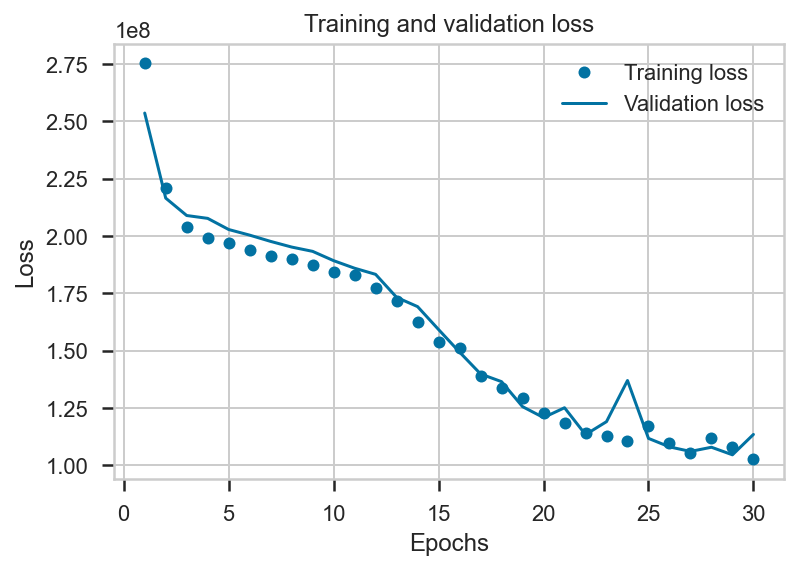

In [71]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

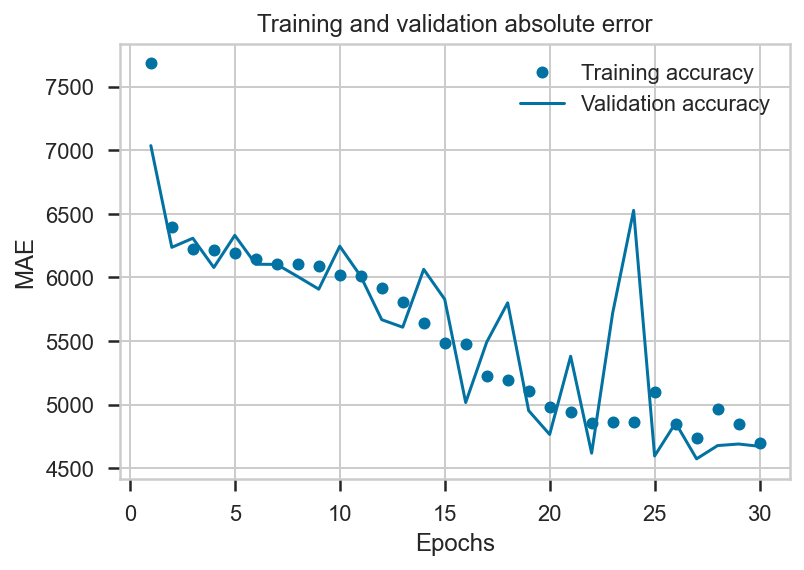

In [72]:
acc = history_dict['mae']
val_acc = history_dict['val_mae']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [73]:
test_predictions = model.predict(X_tsr)

print_metrics(y_tsr, test_predictions.squeeze())

rmse: 10650.55
mae:  4671.50
mrae: 0.48


In [74]:
train_predictions = model.predict(X_trr)

print_metrics(y_trr, train_predictions.squeeze())

rmse: 10437.22
mae:  4664.70
mrae: 0.49
